In [11]:
import multiprocessing.pool
from datetime import datetime
import pandas as pd
import os
import numpy as np
from functools import partial
import dask.dataframe as dd
import dask.multiprocessing
LOB = pd.DataFrame()
import datetime
import os
import dask.dataframe as dd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
from multiprocessing import Pool, freeze_support, Manager
import matplotlib.ticker as mtick
import itertools
colormap = plt.cm.RdBu
plt.style.use(os.path.join(mpl.get_configdir(),'latexstyle.mplstyle'))
from collections import defaultdict

In [152]:
def read_pkl_idx(file_loc, files_list, file_idx):
    file_idx_loc = os.path.join(file_loc, files[file_idx])
    dict_idx = pd.read_pickle(file_idx_loc)
    return dict_idx


In [100]:
mfdfaDataFramesLoc = '/media/ak/T7/August11th2022Experiments/mfdfaDataFrames'
symbol = 'G_1'
symbol_mfdfa_dfs_loc = os.path.join(mfdfaDataFramesLoc, symbol)
bar= 'tick'
symbol_mfdfa_dfs = [f for f in os.listdir(symbol_mfdfa_dfs_loc) if str(bar) in f]

In [106]:
print(len(symbol_mfdfa_dfs))

23


In [101]:
os.listdir(mfdfaDataFramesLoc )

['G_1', 'YM1', 'XM1', 'FB1', 'JB1', 'RX1', 'DU1', 'US1']

In [102]:
os.listdir('/home/ak/.config/matplotlib/')

['latexstyle.mplstyle']

In [108]:
expInputFiles = '/media/ak/Data2/August11th2022Experiments/ExperimentInputFiles/'
figures = '/home/ak/Documents/Research/Papers/StylisedFactsPaper/figures/'

In [109]:
files = os.listdir(expInputFiles)
symbols = ['FB1', 'G_1', 'JB1', 'RX1']
symbol_files_loc = os.path.join(expInputFiles, str(symbol))
symbol_files_list = [f for f in os.listdir(symbol_files_loc) if str(bar) in f]

In [110]:
len(symbol_files_list)

28

In [164]:

gk_vol=dict()
micro_vars = defaultdict(dict)
for i in range(len(symbol_files_list)):
    file_loc = os.path.join(symbol_files_loc, symbol_files_list[i])
    date = file_loc.split("_")[4]
    gk_vol[i]=pd.read_pickle(file_loc)['GK_vol']
    micro_vars['arrival_rates'][file_loc.split("_")[4]] = pd.read_pickle(file_loc)['arrival_rates']
    micro_vars['median_traded_volume'][file_loc.split("_")[4]] =pd.read_pickle(file_loc)['median_traded_volume']
    
                                                   

In [165]:
df = pd.DataFrame.from_dict(gk_vol)
df_vols = df.dropna()
s = df_vols.values.flatten()
q1, q3 = np.quantile(s, 0.33), np.quantile(s, 0.66) # simple thresholding of regimes
median = np.median(s)

In [113]:
lo =  (df<=q1)
hi =  (df>=q3)
med = (df>q1) & (df<q3)

In [ ]:
# list of variables
# ['micro_price', 'price_imbalance', 'pct_change_micro_price',
#        'weighted_activity_spread', 'GK_vol', 'arrival_rates',
#        'returns_normalised', 'returns_mix_max', 'skew', 'kurt',
#        'median_traded_volume', 'jumps_test', 'relz_var', 'trip_quart']

In [ ]:
# pre-mfdfa!

In [114]:
arrival_rates =pd.DataFrame.from_dict(micro_vars['arrival_rates']).dropna()
median_traded_volume =pd.DataFrame.from_dict(micro_vars['median_traded_volume']).dropna()


## volume + arrival rates

In [115]:
df_regime_hi_volume = pd.DataFrame(median_traded_volume.astype(float).values*hi.astype(int).values)
df_regime_lo_volume = pd.DataFrame(median_traded_volume.astype(float).values*lo.astype(int).values)
df_regime_med_volume = pd.DataFrame(median_traded_volume.astype(float).values*med.astype(int).values)


In [116]:
df_regime_hi_arr_rates = pd.DataFrame(arrival_rates.astype(float).values*hi.astype(int).values)
df_regime_lo_arr_rates = pd.DataFrame(arrival_rates.astype(float).values*lo.astype(int).values)
df_regime_med_arr_rates = pd.DataFrame(arrival_rates.astype(float).values*med.astype(int).values)

## plotting arrival rates!

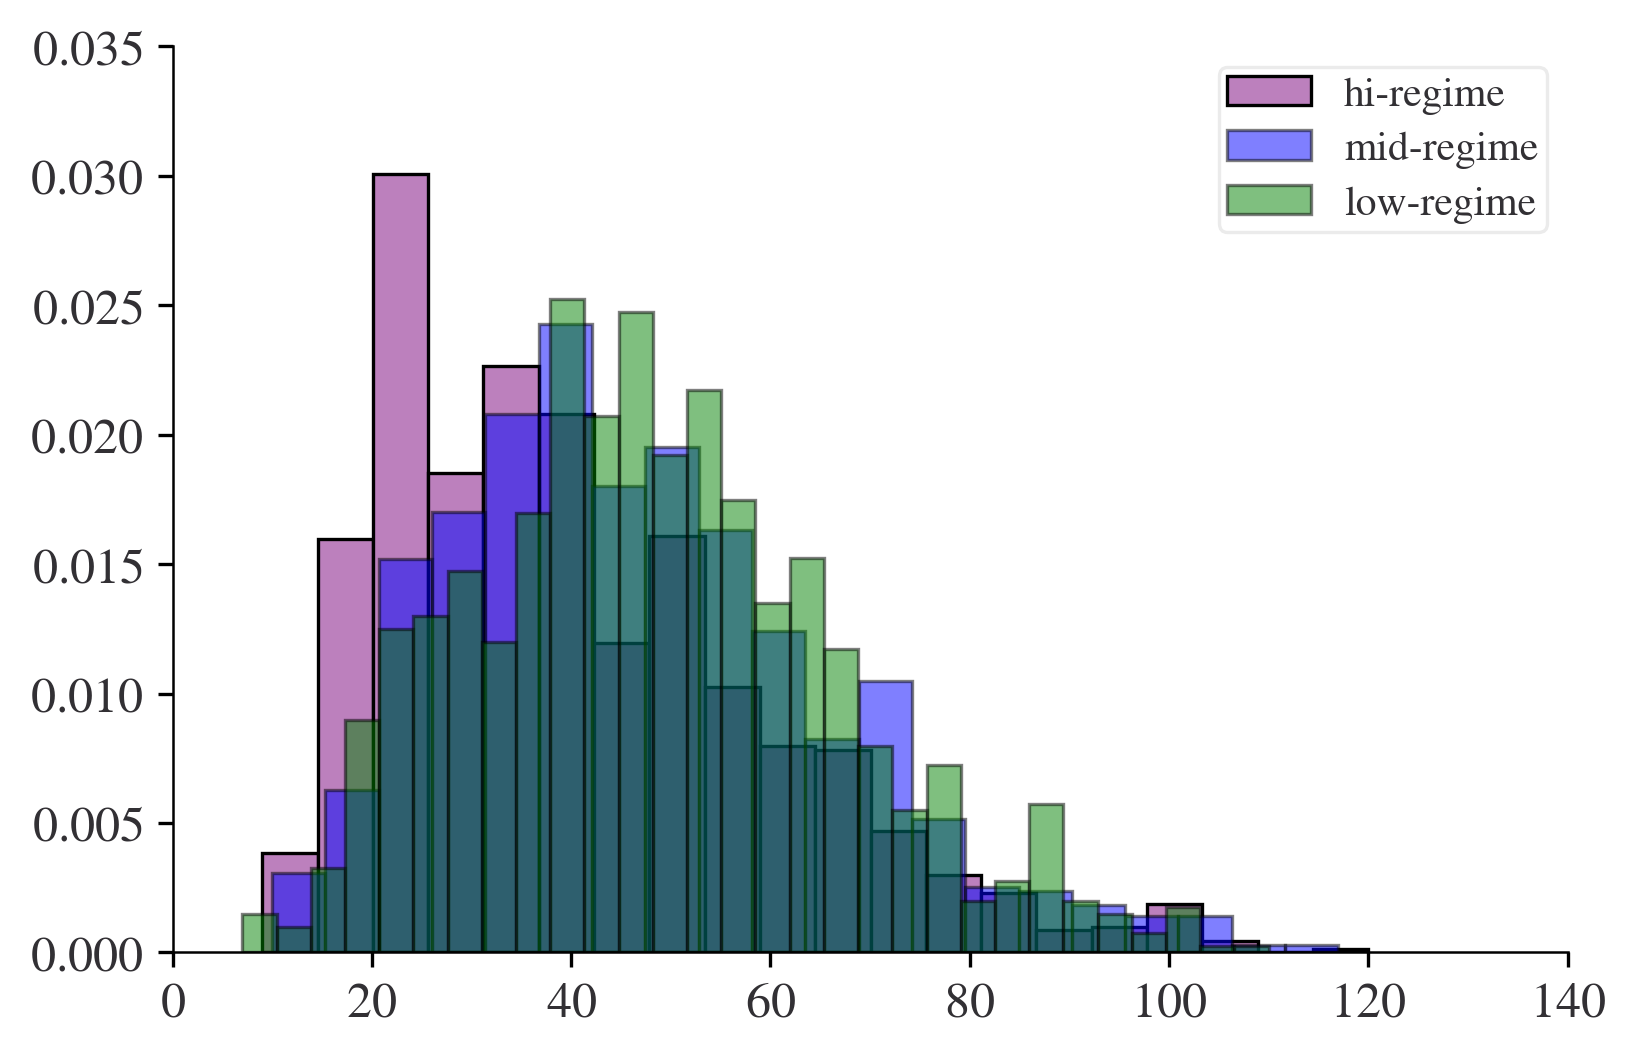

In [126]:
df_regime_hi_non_zero = df_regime_hi_arr_rates[df_regime_hi_arr_rates!=0]
df_regime_mid_non_zero = df_regime_med_arr_rates[df_regime_med_arr_rates!=0]
df_regime_lonw_non_zero = df_regime_lo_arr_rates[df_regime_lo_arr_rates!=0]

_=plt.hist(df_regime_hi_non_zero.median(axis=1), bins=20,density=True, label='hi-regime')
_=plt.hist(df_regime_mid_non_zero.median(axis=1),  bins=20, density=True,color='blue', alpha=0.5, label='mid-regime')
_=plt.hist(df_regime_lonw_non_zero.median(axis=1),  bins=30,density=True, color='green', alpha=0.5, label='low-regime')
title = '3_regime_dist_arrivals'+str(bar)+str(symbol)+'_plot1.png'
fileLocation = os.path.join(figures, title)
plt.savefig(fileLocation, dpi = 150 )
_=plt.legend()


# plotting volumes

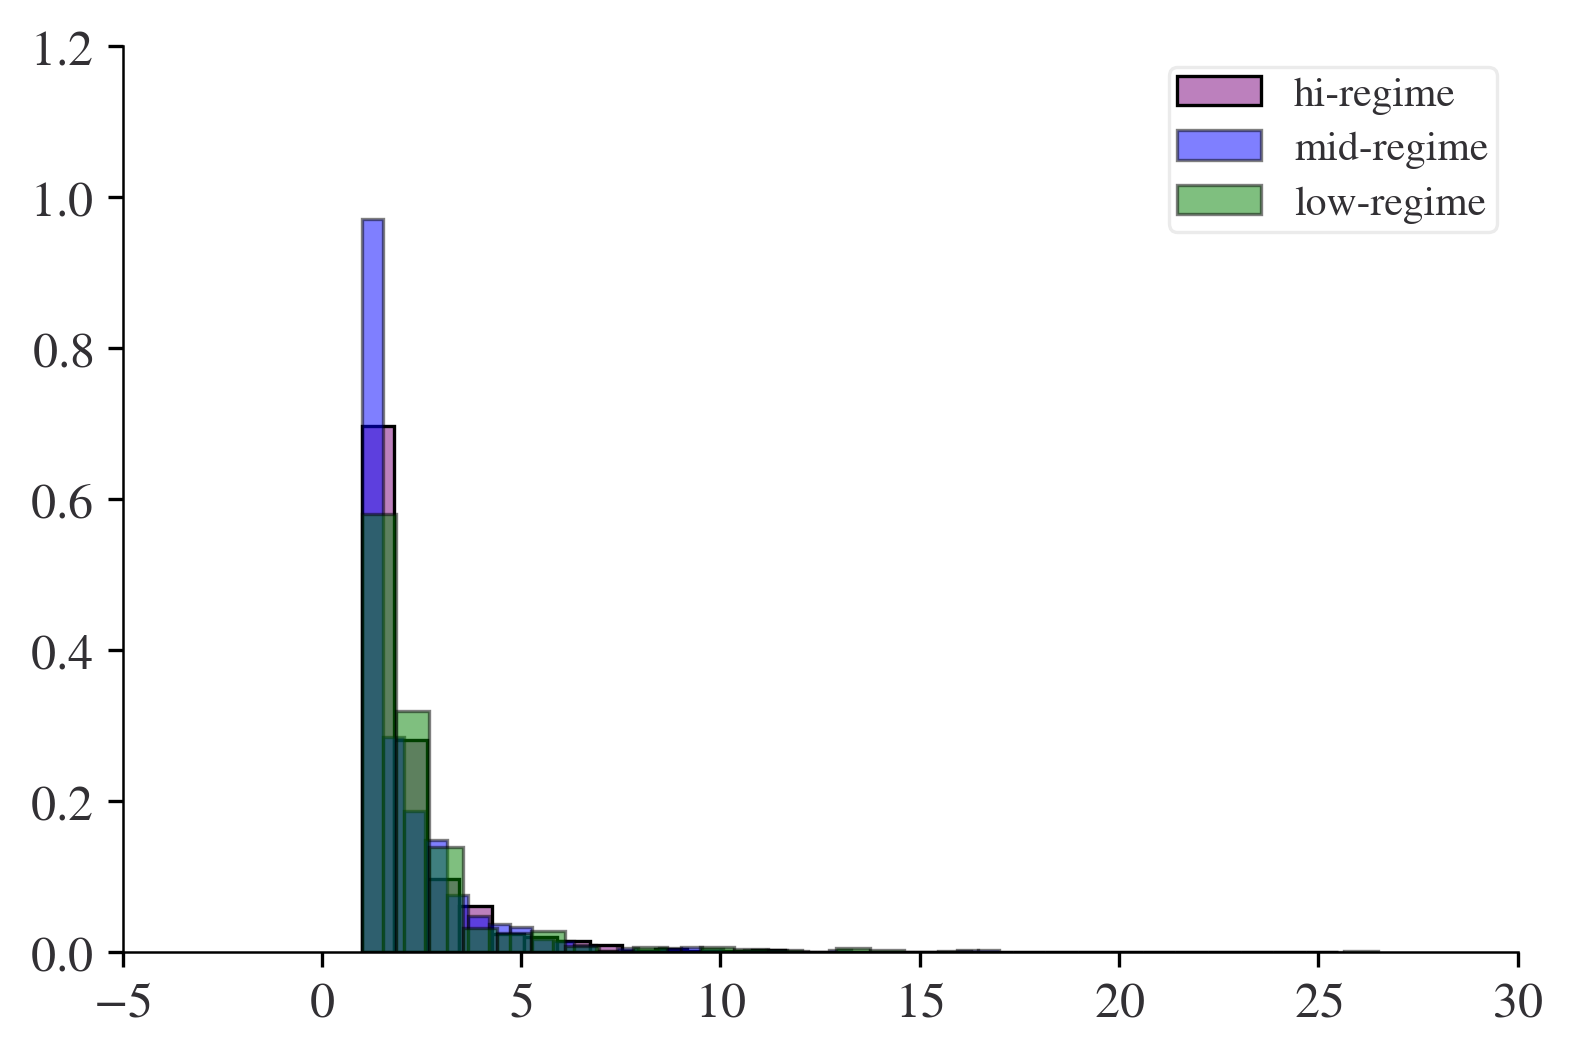

In [119]:
df_regime_hi_volume = df_regime_hi_volume[df_regime_hi_volume!=0]
df_regime_med_volume = df_regime_med_volume[df_regime_med_volume!=0]
df_regime_lo_volume = df_regime_lo_volume[df_regime_lo_volume>0]

_=plt.hist(df_regime_hi_volume.median(axis=1), bins=30,density=True, label='hi-regime')
_=plt.hist(df_regime_med_volume.median(axis=1),  bins=30, density=True,color='blue', alpha=0.5, label='mid-regime')
_=plt.hist(df_regime_lo_volume.median(axis=1),  bins=30,density=True, color='green', alpha=0.5, label='low-regime')
title = '3_regime_dist_volume'+str(bar)+str(symbol)+'_plot1.png'
fileLocation = os.path.join(figures, title)
plt.savefig(fileLocation, dpi = 150 )
_=plt.legend()


## mfdfa

In [200]:
variables = ['n_F', 'list_H', 'list_H_intercept', 'tau', 'alpha', 'mfSpect']
tau_dict= dict()
alpha = dict()
mfSpect= dict()


for testIdx in range(len(symbol_mfdfa_dfs)):
    symbol_file_loc_mfdfa = os.path.join(symbol_mfdfa_dfs_loc, symbol_mfdfa_dfs[testIdx]) 
    tau_dict[testIdx]= pd.read_pickle(symbol_file_loc_mfdfa)[str(bar)]['tau']
    alpha[testIdx]= pd.read_pickle(symbol_file_loc_mfdfa)[str(bar)]['alpha']
    mfSpect[testIdx]= pd.read_pickle(symbol_file_loc_mfdfa)[str(bar)]['alpha']
    


In [142]:
df_tau = pd.DataFrame.from_dict(tau_dict)
df_alpha = pd.DataFrame.from_dict(alpha)
df_mfSpect = pd.DataFrame.from_dict(mfSpect)



In [150]:
t7_folder = '/media/ak/T7/August11th2022Experiments/'
experimentInputFiles = os.path.join(t7_folder,'ExperimentInputFiles')
symbolExperimentInputFiles = os.path.join(experimentInputFiles, symbol)
symbol_bar_files = sorted([f for f in os.listdir(symbolExperimentInputFiles) if str(bar) in f])

In [157]:
idx = 1
symbol_file_loc = os.path.join(symbolExperimentInputFiles, symbol_bar_files[idx])

In [169]:
df_unpickled = pd.read_pickle(symbol_file_loc)

In [174]:
x = df[0].head(100)

In [186]:
y = df_unpickled.GK_vol.values

In [192]:
median = df_unpickled.GK_vol.median(axis=0)
q1_y, q_y3 = np.quantile(y, 0.33), np.quantile(y, 0.66) # simple thresholding of regimes

In [193]:
print(q1_y, q_y3)

0.00026571993724397176 0.00030748469964147915


In [194]:
print(q1, q3)

0.000278804916538879 0.00032216014015129497


In [195]:
print(median)

0.00028574782061258736


In [197]:
len(np.arange(-3, 4, 0.01))

700

In [201]:
pd.read_pickle(symbol_file_loc_mfdfa)

defaultdict(dict,
            {'tick': {'n_F': {10: array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                      4.58437947e-05, 4.61765204e-05, 4.62667633e-05]),
               11: array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                      4.62242533e-05, 4.65476676e-05, 4.66350597e-05]),
               12: array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                      4.66144740e-05, 4.69285702e-05, 4.70130600e-05]),
               13: array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                      4.70149080e-05, 4.73197010e-05, 4.74012518e-05]),
               14: array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                      4.74260646e-05, 4.77215922e-05, 4.78001831e-05]),
               15: array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                      4.78485216e-05, 4.81348462e-05, 4.82104736e-05]),
               16: array([0.00000000e+00, 0.00000000e+00, 0.0